<a href="https://colab.research.google.com/github/zhus-dika/railways_caclulations/blob/main/railways_calculations_volume_data_p1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐸 Getting data from stat.gov

## 🦉 Download spreadsheets & make dataframes

### 🦤 Install need packages

In [1]:
! pip install pyexcel pyexcel-xls pyexcel-xlsx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 5.9 MB/s eta 0:00:00


### 🪲 Imports

In [2]:
import glob
from os import listdir
import os
from os.path import isfile, join
import pyexcel as p

from openpyxl import load_workbook

import pandas as pd

import subprocess

### 🐤 Useful methods

In [3]:
def convert2xlsx():

  files_xlsx = glob.glob("*.xls*")
  files_xls = glob.glob("*.xls")
  files_xlsx.sort(key=os.path.getmtime)
  if len(files_xls) > 0:
    for idx, i in enumerate(files_xls):
        p.save_book_as(file_name=i,
                      dest_file_name=i.replace('.xls', '.xlsx'))
        os.remove(i)
        files_xlsx[idx] = files_xlsx[idx].replace('.xls', '.xlsx')
  return files_xlsx

In [4]:
def prepare_files_rar():
  # get all files to make correct ordering
  files = glob.glob("*")
  files.sort(key=os.path.getmtime)

  file2int = {}

  for idx, file in enumerate(files):
    file2int[file.split('.')[0]] = idx

  # unrar .rar files and remove them
  files_rar = glob.glob("*.rar")

  for file_rar in files_rar:
    correct = subprocess.run(['unrar', '-y', 'x', file_rar], check=True, text=True)
    correct = subprocess.run(['rm', '-r', file_rar], check=True, text=True)

  # move inner files with extensions .xls & .xlsx
  for path in files_rar:
    files = os.listdir(path=path[:-4])
    files_xls = glob.glob(f"{path[:-4]}/*.xls")

    if len(files_xls) > 1:
      for file_xls in files_xls:
        if os.path.join(path[:-4], "3. Производство промышленной продукции в натуральном выражении.xls") != file_xls:
          correct = subprocess.run(['rm', '-r', file_xls], check=True, text=True)

    files_xls = glob.glob(f"{path[:-4]}/*.xls")
    for selected_file in files_xls:
      os.rename(selected_file, f"{path[:-4]}.xls")
    files_xlsx = glob.glob(f"{path[:-4]}/*.xlsx")
    for selected_file in files_xlsx:
      os.rename(selected_file, f"{path[:-4]}.xlsx")


  files_xlsx = glob.glob("*.xls*")
  files_xls = glob.glob("*.xls")

  files_xlsx = convert2xlsx()

  files_xlsx_upd = [i for i in files_xlsx]

  for file_xlsx in files_xlsx:
    files_xlsx_upd[file2int[file_xlsx.split('.')[0]]] = file_xlsx

  return files_xlsx_upd

In [5]:
def generate_table_data(files_xlsx):

  table_data = []
  for i in files_xlsx:
    wb = load_workbook(i)
    main_sheets = ["3 табл", "3", "3 ", " 3", "Лист1", "бюллетень 2 мес", "бюллетень 4 мес", "бюллетень 6 мес", "бюллетень 8 мес", "бюллетень 10 мес", "бюллетень 12 мес", "Данные"]
    for main_sheet in main_sheets:
      if main_sheet in wb.sheetnames:
        table_data.append(wb[main_sheet])
        break
  return table_data

In [6]:
def fill_volumes(table_data, year, name_column='J'):

  commodities_names = []

  table_rows = []
  for table_num in range(len(table_data)):
    commodities_names_2 = []
    rows = {}
    for i in range(8, 354):
      if table_data[table_num]['I'+str(i)].value != None and table_data[table_num][name_column + str(i)].value != None:
        value = table_data[table_num][name_column+str(i)].value
        value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').replace("\n", " ").lower()
        name = " ".join(value.split())
        if 'гранулы крошка каменная и порошок каменный; галька гравий щебень или камень дробленый тыс куб м' == name:
          name = 'гранулы крошка каменная и порошок каменный; галька гравий щебень или камень дробленный тыс куб м'
        if 'золото необработанное и полуобработанное или в виде порошка кг' == name:
          name = 'золото необработанное и полу обработанное или в виде порошка кг'
        commodities_names_2.append(name)
        rows[name] = i
    table_rows.append(rows)
    commodities_names.append(commodities_names_2)
  commodities_volumes = {str(i) + '_' + str(year): [] for i in range(1, 13)}
  commodities_volumes['name'] = []
  common_names = set(commodities_names[0])
  for i in range(1, 6):
    common_names = common_names & set(commodities_names[i])

  for name in common_names:

    commodities_volumes['name'].append(name)

    for table_num in range(len(table_data)):

      i = table_rows[table_num][name]
      val_volume_1 = table_data[table_num]['B'+str(i)].value
      commodities_volumes[str(2 * table_num + 1) + '_' + str(year)].append(val_volume_1)
      val_volume_2 = table_data[table_num]['C'+str(i)].value
      commodities_volumes[str(2 * table_num + 2)  + '_' + str(year)].append(val_volume_2)
  return commodities_volumes

### 🦜 2018 year per month

In [7]:
! rm -r *

In [8]:
# ! wget https://stat.gov.kz/api/iblock/element/49161/file/ru/

In [9]:
! wget 'https://stat.gov.kz/upload/iblock/902/aobfv3djds58bmyhkqaktyjpzb2iuybc/2_2018_%D0%91-04-01-%D0%9C.rar' #1-2
! wget 'https://stat.gov.kz/upload/iblock/fb0/9j1tlw2sf4gcrm0q9vjhrl6o9t9rc7v8/4_2018_%D0%91-04-01-%D0%9C.rar' #1-4
! wget 'https://stat.gov.kz/upload/iblock/919/dwds1m0pf83dbdpucwfa0e16o162wm4f/6_2018_%D0%91-04-01-%D0%9C.rar' #1-6
! wget 'https://stat.gov.kz/upload/iblock/7b5/qf2p59p7wnjpbgy23say98ls1ruzf3x5/8_2018_%D0%91-04-01-%D0%9C.rar' #1-8
! wget 'https://stat.gov.kz/upload/iblock/ef8/kj8ilh6pam18b1m5bkfgx8pcf4h7iav9/10_2018_%D0%91-04-01-%D0%9C.rar' #1-10
! wget 'https://stat.gov.kz/upload/iblock/890/bw4d5zwmn1i1rosuz2ifvfa4qgw7haa1/12_2018_%D0%91-04-01-%D0%9C.rar' #1-12

--2025-02-11 09:50:28--  https://stat.gov.kz/upload/iblock/902/aobfv3djds58bmyhkqaktyjpzb2iuybc/2_2018_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154352 (151K) [application/x-rar-compressed]
Saving to: ‘2_2018_Б-04-01-М.rar’

2_2018_Б-04-01-М.ra 100%[===================>] 150.73K   243KB/s    in 0.6s    

2025-02-11 09:50:29 (243 KB/s) - ‘2_2018_Б-04-01-М.rar’ saved [154352/154352]

--2025-02-11 09:50:29--  https://stat.gov.kz/upload/iblock/fb0/9j1tlw2sf4gcrm0q9vjhrl6o9t9rc7v8/4_2018_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154410 (151K) [application/x-rar-compressed]
Saving to: ‘4_2018_Б-04-01-М.rar’

4_2018_Б-04-01-М.ra 100%[===================>] 150.79K   242

In [10]:
files_xlsx = prepare_files_rar()

In [11]:
df_2018 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2018))
df_2018

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,11_2018,12_2018,name
0,34664.0,40847.5,49720.8,48523.6,53180.1,57565.5,63215.1,57261,44029.9,41034.1,43485.6,52287.6,воды минеральные и газированные неподслащенные...
1,4563.0,5319.0,5721.0,4874.0,3497.0,9878.0,6304.0,7804,9914.0,8523,8871.0,10219,одежда верхняя трикотажная машинного или ручно...
2,1317.0,1411.0,1882.0,2271.0,2328.0,3033.0,1343.0,1464,1723.0,1112,1203.0,1250,масло соевое и его фракции тонн
3,288.2,250.9,291.7,290.8,298.8,341.5,361.4,339.8,379.7,403.3,352.9,370.2,топливо моторное бензин в том числе авиационны...
4,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,14220.0,21893,рис полуобрушенный или полностью обрушенный ил...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,585.4,848.7,843.3,877.5,514.8,585.4,541.7,810.8,830.1,770.9,1029.3,997.3,гранит песчаник и камень для памятников отделк...
246,252711.0,228301.0,270364.0,262112.0,258838.0,188680.0,277329.0,278771,187756.0,171813,106813.0,64480,плоский прокат тонн
247,140.9,146.9,147.9,147.9,147.7,149.7,151.7,145.4,143.4,145.4,155.1,155.1,мел и доломит некальцинированный тыс тонн
248,22169.0,27300.0,22527.0,12361.0,33527.0,28059.0,30754.0,30450,17679.0,25899,38231.0,36653,цистерны бочки барабаны канистры ящики и емкос...


### 🐨 2019 year per month

In [12]:
! rm -r *

In [13]:
# ! wget https://stat.gov.kz/api/iblock/element/49133/file/ru/

In [14]:
! wget 'https://stat.gov.kz/upload/iblock/3d0/spwao8pmj590p21oj6jjmrsa84gcaeup/02_2019_%D0%91-04-01-%D0%9C.rar' #1-2
! wget 'https://stat.gov.kz/upload/iblock/577/f20py2ccajbmf5o4kacuiv355iz42wv6/04_2019_%D0%91-04-01-%D0%9C.xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/fe4/z6wj3wuac71s3u7xc6pv26ozo0yba8sp/06_2019_%D0%91-04-01-%D0%9C.xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/0e7/jlalo81y1p4tdoi01u3yojfccv7q99h2/08_2019_%D0%91-04-01-%D0%9C.xls' #1-8
! wget 'https://stat.gov.kz/upload/iblock/d29/79ljbm8q3ibp0svmm6y4us55f3ql6xlo/10_2019_%D0%91-04-01-%D0%9C.xls' #1-10
! wget 'https://stat.gov.kz/upload/iblock/505/b3iaejrhcby1o5qf3wu5tlarbeqwhu7c/12_2019_%D0%91-04-01-%D0%9C.xls' #1-12

--2025-02-11 09:50:41--  https://stat.gov.kz/upload/iblock/3d0/spwao8pmj590p21oj6jjmrsa84gcaeup/02_2019_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154632 (151K) [application/x-rar-compressed]
Saving to: ‘02_2019_Б-04-01-М.rar’

02_2019_Б-04-01-М.r 100%[===================>] 151.01K   243KB/s    in 0.6s    

2025-02-11 09:50:43 (243 KB/s) - ‘02_2019_Б-04-01-М.rar’ saved [154632/154632]

--2025-02-11 09:50:43--  https://stat.gov.kz/upload/iblock/577/f20py2ccajbmf5o4kacuiv355iz42wv6/04_2019_%D0%91-04-01-%D0%9C.xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276480 (270K) [application/vnd.ms-excel]
Saving to: ‘04_2019_Б-04-01-М.xls’

04_2019_Б-04-01-М.x 100%[===================>] 270.00K   32

In [15]:
files_xlsx = prepare_files_rar()

In [16]:
df_2019 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2019))
df_2019

,1_2019,2_2019,3_2019,4_2019,5_2019,6_2019,7_2019,8_2019,9_2019,10_2019,11_2019,12_2019,name
0,37884.8,41141.2,54093.8,58366.3,59438.8,83466.2,69776.1,76543.9,53238.9,43894.8,51571.1,44474.2,воды минеральные и газированные неподслащенные...
1,6344.0,7810,7205,9272,50727.0,8431.0,5835.0,11602.0,11530.0,12444.0,13057.0,13867.0,одежда верхняя трикотажная машинного или ручно...
2,378.9,268.7,268.9,305.6,365.3,388.5,346.9,458.6,465.6,400.4,423.3,469.2,топливо моторное бензин в том числе авиационны...
3,9377.0,16073,14164,14191,10211.0,10198.0,9327.0,8115.0,8094.0,8105.0,12121.0,24247.0,рис полуобрушенный или полностью обрушенный ил...
4,7208.0,12397,10593,6957,407.0,407.0,407.0,1.0,132.0,8995.0,12625.0,12048.0,хлопок кардо и гребнечесаный тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,69932.0,112738,208279,211036,234323.0,204899.0,248179.0,214323.0,125383.0,105793.0,125856.0,176076.0,плоский прокат тонн
233,321856.0,370385,872070,388683,352496.0,444673.0,388845.0,462163.0,381670.0,446671.0,338451.0,364240.0,препараты фармацевтические прочие тыс тенге
234,145.7,130.1,135.1,136.1,136.0,132.0,137.0,148.8,148.8,140.8,176.8,171.8,мел и доломит некальцинированный тыс тонн
235,26018.0,39210,37532,37376,51195.0,39504.0,54921.0,50433.0,48029.0,49956.0,63956.0,65225.0,цистерны бочки барабаны канистры ящики и емкос...


In [17]:
df = df_2018.set_index('name').join(df_2019.set_index('name'), on='name')

### 🐻 2020 year per month

In [18]:
! rm -r *

In [19]:
# ! wget https://stat.gov.kz/api/iblock/element/49113/file/ru/

In [20]:
! wget 'https://stat.gov.kz/upload/iblock/a8a/h7odaow8re9jy36o2defzgd8lloud61b/02_2020_%D0%91-04-01-%D0%9C.xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/6a6/o9fy7vi1unm3f6qyyblpbbr0biyx7ubo/%D0%91-04-01-%D0%9C%20(4%202020).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/29d/t128ej0f1edw811ho2491cat3x3fgm1e/%D0%91-04-01-%D0%9C%20(6%202020).xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/a77/xum5h2ea3anc1gy960xz0z4fibfc2qxn/%D0%91-04-01-%D0%9C(8%202020).rar' #1-8
! wget 'https://stat.gov.kz/upload/iblock/b86/h9a0m5kw5wqvk9yt0d9e4ko5ozd862es/%D0%91-04-01-%D0%9C(10%202020).rar' #1-10
! wget 'https://stat.gov.kz/upload/iblock/d67/t8bp3s2mobqxlbp7aobn0m0di43etmmz/%D0%91-04-01-%D0%9C%20(12%202020).rar' #1-12

--2025-02-11 09:50:56--  https://stat.gov.kz/upload/iblock/a8a/h7odaow8re9jy36o2defzgd8lloud61b/02_2020_%D0%91-04-01-%D0%9C.xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287232 (280K) [application/vnd.ms-excel]
Saving to: ‘02_2020_Б-04-01-М.xls’

02_2020_Б-04-01-М.x 100%[===================>] 280.50K   169KB/s    in 1.7s    

2025-02-11 09:50:59 (169 KB/s) - ‘02_2020_Б-04-01-М.xls’ saved [287232/287232]

--2025-02-11 09:50:59--  https://stat.gov.kz/upload/iblock/6a6/o9fy7vi1unm3f6qyyblpbbr0biyx7ubo/%D0%91-04-01-%D0%9C%20(4%202020).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312320 (305K) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (4 2020).xls’

Б-04-01-М (4 2020). 100%[===================>] 305.00K   

In [21]:
files_xlsx = prepare_files_rar()

df_2020 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2020))

In [22]:
df_2020

,1_2020,2_2020,3_2020,4_2020,5_2020,6_2020,7_2020,8_2020,9_2020,10_2020,11_2020,12_2020,name
0,41619.3,47873.4,54449.7,41035,53210.8,64019.9,55750.6,55217.5,48495.7,42394.5,43555.1,40805.5,воды минеральные и газированные неподслащенные...
1,5393,10694,10067,9194,5308,9673,6104,5755,8442,4718,10203,10175,одежда верхняя трикотажная машинного или ручно...
2,426.6,404.5,342.9,289.6,310.7,340.5,384.6,373,380.2,417,412.9,413.7,топливо моторное бензин в том числе авиационны...
3,9337,22381,22399,22270,16750,15392,14764,13763,13739,13758,12716,23041,рис полуобрушенный или полностью обрушенный ил...
4,9627,10364,7981,7014,2351,2351,2351,-,172,8864,13054,10496,хлопок кардо и гребнечесаный тонн
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,374095,805632,719619,745913,742377,746402,790426,564106,509400,488147,436841,445006,препараты фармацевтические прочие тыс тенге
272,127,165.9,171.7,170.2,154.6,158.2,159.2,160.7,163.6,163.7,142.7,142.7,мел и доломит некальцинированный тыс тонн
273,41323,93652,90797,90832,62542,62570,62618,45786,45885,46223,84234,84234,изделия ювелирные и аналогичные тыс тенге
274,52868,35163,40964,29633,24196,42385,42274,38589,33539,34109,34515,58206,цистерны бочки барабаны канистры ящики и емкос...


In [23]:
df = df.join(df_2020.set_index('name'), on='name')

In [24]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2020,4_2020,5_2020,6_2020,7_2020,8_2020,9_2020,10_2020,11_2020,12_2020
name,,,,,,,,,,,,,,,,,,,,,
воды минеральные и газированные неподслащенные и неароматизированные тыс литров,34664.0,40847.5,49720.8,48523.6,53180.1,57565.5,63215.1,57261,44029.9,41034.1,...,54449.7,41035,53210.8,64019.9,55750.6,55217.5,48495.7,42394.5,43555.1,40805.5
одежда верхняя трикотажная машинного или ручного вязания штук,4563.0,5319.0,5721.0,4874.0,3497.0,9878.0,6304.0,7804,9914.0,8523,...,10067,9194,5308,9673,6104,5755,8442,4718,10203,10175
масло соевое и его фракции тонн,1317.0,1411.0,1882.0,2271.0,2328.0,3033.0,1343.0,1464,1723.0,1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
топливо моторное бензин в том числе авиационный тыс тонн,288.2,250.9,291.7,290.8,298.8,341.5,361.4,339.8,379.7,403.3,...,342.9,289.6,310.7,340.5,384.6,373,380.2,417,412.9,413.7
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,22399,22270,16750,15392,14764,13763,13739,13758,12716,23041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
гранит песчаник и камень для памятников отделки или строительства прочий тыс куб м,585.4,848.7,843.3,877.5,514.8,585.4,541.7,810.8,830.1,770.9,...,526.3,526.9,514.7,510.8,500.3,634.9,637.5,636.1,629.1,630.6
плоский прокат тонн,252711.0,228301.0,270364.0,262112.0,258838.0,188680.0,277329.0,278771,187756.0,171813,...,199092,212524,206051,220671,252126,252292,214947,199445,201170,282598
мел и доломит некальцинированный тыс тонн,140.9,146.9,147.9,147.9,147.7,149.7,151.7,145.4,143.4,145.4,...,171.7,170.2,154.6,158.2,159.2,160.7,163.6,163.7,142.7,142.7


### 🦀 2021 year per month

In [25]:
! rm -r *

In [26]:
# ! wget https://stat.gov.kz/api/iblock/element/25859/file/ru/

In [27]:
# Download files

! wget 'https://stat.gov.kz/upload/iblock/c68/qi23tyw55ano3t937wmy34ccjz16md7n/%D0%91-04-01-%D0%9C%20(2%202021).xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/5ac/er3ckeib0oty9c5eu89z7y21fj9pddah/%D0%91-04-01-%D0%9C(4%202021).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/ecb/d762kfgimmp261jo92zit8gcu366tck6/%D0%91-04-01(06%202021)%D0%9C.xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/06d/r2aw5v5w0gkuqi5l1ip3pbn3se1lub7d/%D0%91-04-01-%D0%9C%20(8%202021).xls' #1-8
! wget 'https://stat.gov.kz/upload/iblock/3d2/p61m6ici74ma0ii2g1uh5mkxxnyx3cpd/%D0%91-04-01-%D0%9C%20(10%202021).xls' #1-10
! wget 'https://stat.gov.kz/upload/iblock/386/frszzq01e16r2ywhp47tqb0nnkzjtwlq/%D0%91-04-01-%D0%9C%20(12%202021).xls' #1-12

--2025-02-11 09:51:19--  https://stat.gov.kz/upload/iblock/c68/qi23tyw55ano3t937wmy34ccjz16md7n/%D0%91-04-01-%D0%9C%20(2%202021).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1282048 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (2 2021).xls’

Б-04-01-М (2 2021). 100%[===================>]   1.22M   255KB/s    in 5.4s    

2025-02-11 09:51:25 (230 KB/s) - ‘Б-04-01-М (2 2021).xls’ saved [1282048/1282048]

--2025-02-11 09:51:25--  https://stat.gov.kz/upload/iblock/5ac/er3ckeib0oty9c5eu89z7y21fj9pddah/%D0%91-04-01-%D0%9C(4%202021).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225728 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М(4 2021).xls’

Б-04-01-М(4 2021).x 100%[===================>]   1

In [28]:
files_xlsx = convert2xlsx()

df_2021 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2021))

In [29]:
df_2021

,1_2021,2_2021,3_2021,4_2021,5_2021,6_2021,7_2021,8_2021,9_2021,10_2021,11_2021,12_2021,name
0,1862,2736,2736,2736,135,135,135,100,100,100,15,15,приемники телевизионные объединенные или нет с...
1,34603.3,44082.7,53074.4,56407.8,69212.8,69718.7,72806.4,70987.8,54681.9,46734.5,43559.6,45151.2,воды минеральные и газированные неподслащенные...
2,408.1,387.5,362.7,388.8,308.2,384.2,448.4,435.5,394.7,376.3,432,489.5,топливо моторное бензин в том числе авиационны...
3,7243,2473,2455,2521,2683,2762,2789,3856,3922,3844,2874,2866,рыба свежая охлажденная или мороженая тонна ме...
4,14806,18785,18603,18860,19645,21036,20209,16463,16447,16439,14569,14827,рис полуобрушенный или полностью обрушенный ил...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,777106,674350,677693,678808,1098396,1049264,17924478,10961977,4455483,2505349,1067841,1090065,препараты фармацевтические прочие тыс тенге
286,156.8,176.2,175.5,176.4,157.7,157.1,156.2,172.7,172.2,173,172.9,173.1,мел и доломит некальцинированный тыс тонн
287,65000,96560,97936,93100,98664,96194,96073,151088,152932,151989,99781,101051,изделия ювелирные и аналогичные тыс тенге
288,39429,58427,56448,59729,30528,38206,47214,40801,41242,39631,38203,37247,цистерны бочки барабаны канистры ящики и емкос...


In [30]:
df = df.join(df_2021.set_index('name'), on='name')

In [31]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2021,4_2021,5_2021,6_2021,7_2021,8_2021,9_2021,10_2021,11_2021,12_2021
name,,,,,,,,,,,,,,,,,,,,,
воды минеральные и газированные неподслащенные и неароматизированные тыс литров,34664.0,40847.5,49720.8,48523.6,53180.1,57565.5,63215.1,57261,44029.9,41034.1,...,53074.4,56407.8,69212.8,69718.7,72806.4,70987.8,54681.9,46734.5,43559.6,45151.2
одежда верхняя трикотажная машинного или ручного вязания штук,4563.0,5319.0,5721.0,4874.0,3497.0,9878.0,6304.0,7804,9914.0,8523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
масло соевое и его фракции тонн,1317.0,1411.0,1882.0,2271.0,2328.0,3033.0,1343.0,1464,1723.0,1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
топливо моторное бензин в том числе авиационный тыс тонн,288.2,250.9,291.7,290.8,298.8,341.5,361.4,339.8,379.7,403.3,...,362.7,388.8,308.2,384.2,448.4,435.5,394.7,376.3,432,489.5
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,18603,18860,19645,21036,20209,16463,16447,16439,14569,14827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
гранит песчаник и камень для памятников отделки или строительства прочий тыс куб м,585.4,848.7,843.3,877.5,514.8,585.4,541.7,810.8,830.1,770.9,...,596,573.8,310.7,309.4,306.1,501,454.2,491.8,582.6,566.2
плоский прокат тонн,252711.0,228301.0,270364.0,262112.0,258838.0,188680.0,277329.0,278771,187756.0,171813,...,257486,250396,290497,211558,285869,280532,173544,199060,350489,350550
мел и доломит некальцинированный тыс тонн,140.9,146.9,147.9,147.9,147.7,149.7,151.7,145.4,143.4,145.4,...,175.5,176.4,157.7,157.1,156.2,172.7,172.2,173,172.9,173.1


### 🦢 2022 year per month

In [32]:
! rm -r *

In [33]:
# ! wget https://stat.gov.kz/api/iblock/element/25889/file/ru/

In [34]:
# Download files

! wget 'https://stat.gov.kz/upload/iblock/619/kuvf04586dczijein9r530o2lj9k4h9a/%D0%91-04-01-%D0%9C%20(2%202022).xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/bf7/76q3suej6kom8k8k1jq7l2eku5d6cyrc/%D0%91-04-01-%D0%9C%20(4%202022).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/6db/ooibr2vg9jm0hxjq8a4tqni7ppdyj5bc/%D0%91-04-01-%D0%9C%20(6%202022).xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/e58/fceee9uuxjigtckmckdzgiotgwusod36/%D0%91-04-01-%D0%9C%20(08%202022).xlsx' #1-8
! wget 'https://stat.gov.kz/upload/iblock/b50/2y6sn3sifmk9dcqg9ekc65nvhn0tzth2/%D0%91-04-01-%D0%9C(10%202022).xlsx' #1-10
! wget 'https://stat.gov.kz/upload/iblock/ba3/9ue4r2v84puih1lolmooegwx4cefb4hx/%D0%91-04-01-%D0%9C(12_2022).xlsx' #1-12

--2025-02-11 09:51:59--  https://stat.gov.kz/upload/iblock/619/kuvf04586dczijein9r530o2lj9k4h9a/%D0%91-04-01-%D0%9C%20(2%202022).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1224704 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (2 2022).xls’

Б-04-01-М (2 2022). 100%[===================>]   1.17M   244KB/s    in 5.8s    

2025-02-11 09:52:06 (206 KB/s) - ‘Б-04-01-М (2 2022).xls’ saved [1224704/1224704]

--2025-02-11 09:52:06--  https://stat.gov.kz/upload/iblock/bf7/76q3suej6kom8k8k1jq7l2eku5d6cyrc/%D0%91-04-01-%D0%9C%20(4%202022).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1229312 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (4 2022).xls’

Б-04-01-М (4 2022). 100%[===================>]

In [35]:
files_xlsx = convert2xlsx()

df_2022 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2022))

In [36]:
df_2022

,1_2022,2_2022,3_2022,4_2022,5_2022,6_2022,7_2022,8_2022,9_2022,10_2022,11_2022,12_2022,name
0,135,-,-,-,1751,1751,1751,1549,1549,1549,929,929,приемники телевизионные объединенные или нет с...
1,38031.3,46932.2,54298.9,55806,66075.9,65802.2,71886,61510.4,49628,45125.2,49606.7,52111.2,воды минеральные и газированные неподслащенные...
2,7319,9728,9637,9941,13487,10925,13425,18175,15452,15739,19239,21043,одежда верхняя трикотажная машинного или ручно...
3,409.8,385.5,410.1,403.4,428.9,434.7,351.9,433.9,456.5,385.4,381.7,484.7,топливо моторное бензин в том числе авиационны...
4,20582,16334,17642,16948,17452,28135,18477,19648,21434,19802,13631,13850,рис полуобрушенный или полностью обрушенный ил...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,1064372,2223792,2179423,2183659,1261454,1258694,1284732,1494413,1621904,1473038,1008048,829378,препараты фармацевтические прочие тыс тенге
286,157.9,91.1,91.2,91.2,119.9,119.9,116.3,100.4,100.4,100.1,126.6,126.6,мел и доломит некальцинированный тыс тонн
287,95909,103410,103410,103756,71879,90455,104330,157381,157167,157358,102568,110044,изделия ювелирные и аналогичные тыс тенге
288,41653,49357,51989,33968,34845,39082,32822,38831,32377,45238,37685,37639,цистерны бочки барабаны канистры ящики и емкос...


In [37]:
df = df.join(df_2022.set_index('name'), on='name')

In [38]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2022,4_2022,5_2022,6_2022,7_2022,8_2022,9_2022,10_2022,11_2022,12_2022
name,,,,,,,,,,,,,,,,,,,,,
воды минеральные и газированные неподслащенные и неароматизированные тыс литров,34664.0,40847.5,49720.8,48523.6,53180.1,57565.5,63215.1,57261,44029.9,41034.1,...,54298.9,55806,66075.9,65802.2,71886,61510.4,49628,45125.2,49606.7,52111.2
одежда верхняя трикотажная машинного или ручного вязания штук,4563.0,5319.0,5721.0,4874.0,3497.0,9878.0,6304.0,7804,9914.0,8523,...,9637,9941,13487,10925,13425,18175,15452,15739,19239,21043
масло соевое и его фракции тонн,1317.0,1411.0,1882.0,2271.0,2328.0,3033.0,1343.0,1464,1723.0,1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
топливо моторное бензин в том числе авиационный тыс тонн,288.2,250.9,291.7,290.8,298.8,341.5,361.4,339.8,379.7,403.3,...,410.1,403.4,428.9,434.7,351.9,433.9,456.5,385.4,381.7,484.7
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,17642,16948,17452,28135,18477,19648,21434,19802,13631,13850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
гранит песчаник и камень для памятников отделки или строительства прочий тыс куб м,585.4,848.7,843.3,877.5,514.8,585.4,541.7,810.8,830.1,770.9,...,545.7,523.7,478.7,439.1,366.9,565.6,579.2,577.6,805.6,808.6
плоский прокат тонн,252711.0,228301.0,270364.0,262112.0,258838.0,188680.0,277329.0,278771,187756.0,171813,...,233280,187476,175191,200651,231114,221558,224178,221949,202910,226589
мел и доломит некальцинированный тыс тонн,140.9,146.9,147.9,147.9,147.7,149.7,151.7,145.4,143.4,145.4,...,91.2,91.2,119.9,119.9,116.3,100.4,100.4,100.1,126.6,126.6


🐟 Find similar commodities

In [39]:
# from sentence_transformers import SentenceTransformer

# # 1. Load a pretrained Sentence Transformer model
# model = SentenceTransformer("sentence-transformers/all-roberta-large-v1")
# #model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
# #model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# # 2. Calculate embeddings by calling model.encode()
# embeddings_2021 = model.encode(commodities[:200])
# embeddings_2022 = model.encode(commodities_2022[:200])

In [40]:
# import torch

# # Calculate the embedding similarities
# for idx, item in enumerate(embeddings_2021):
#   similarities = model.similarity(item, embeddings_2022)
#   arg_max = int(torch.argmax(similarities[0]))
#   if idx != arg_max:
#     print(similarities)
#     print(f'#{idx} {commodities[idx]} similar ---> #{arg_max} {commodities_2022[arg_max]}')

### 🐝 2023 year per month

In [41]:
! rm -r *

In [42]:
# ! wget https://stat.gov.kz/api/iblock/element/116269/file/ru/

In [43]:
! wget 'https://stat.gov.kz/upload/iblock/036/k7czdxq4q1w65yingnw1rt4cqqcd0oa1/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D1%84%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/56c/olaqz9r8bsi3472oj8lzxweqd9qfk6du/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B0%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/246/rsr5pqpx7d0s8966ao1g0y0v1jc44gbg/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B8%D1%8E%D0%BD%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/c1f/foykqwkcf7gucg8qtvhh784u8l4a65ez/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B0%D0%B2%D0%B3%D1%83%D1%81%D1%82%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/800/o82oc3itd637bo5uex74qwo4s2w6dppd/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%BE%D0%BA%D1%82%D1%8F%D0%B1%D1%80%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/467/kj91lkh84dytwmor4pgbo1ih5g8urrwg/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B4%D0%B5%D0%BA%D0%B0%D0%B1%D1%80%D1%8C%202023%D0%B3).xlsx'

--2025-02-11 09:52:36--  https://stat.gov.kz/upload/iblock/036/k7czdxq4q1w65yingnw1rt4cqqcd0oa1/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D1%84%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C%202023%D0%B3).xlsx
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43667 (43K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘Производство промышленной продукции в натуральном выражении (январь-февраль 2023г).xlsx’

Производство промыш 100%[===================>]  42.64K   206KB/s    in 0.2s    

2025-02-11 09:52

In [44]:
files_xlsx = convert2xlsx()

df_2023 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2023, name_column='A'))

In [45]:
df_2023

,1_2023,2_2023,3_2023,4_2023,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023,name
0,1751,-,-,-,2040,440,440,815,815,815,1151,1151,приемники телевизионные объединенные или нет с...
1,41285.3,47769.3,53771.5,62607,67752.9,71157.8,74077.4,74941.2,53510.3,45800.3,47948.4,44711,воды минеральные и газированные неподслащенные...
2,8216,17360,17192,17991,12565,11212,12443,16032,13783,12889,21262,22672,одежда верхняя трикотажная машинного или ручно...
3,494.1,378.7,407.9,423.2,472.1,409.3,328.4,521.5,492.9,398.6,489.8,494.2,топливо моторное бензин в том числе авиационны...
4,15650,14439,13325,14763,13893,21861,13897,25363,32774,11240,13124,14769,рис полуобрушенный или полностью обрушенный ил...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,1307901,762678,790679,829742,787807,826535,815199,914515,896332,925127,930996,908415,препараты фармацевтические прочие тыс тенге
288,142,174.6,162.6,157.6,162,162,156,140.5,140.5,172.5,199.1,142.1,мел и доломит некальцинированный тыс тонн
289,91078,120893,120937,123378,72960,74538,74111,110016,110463,108946,99577,116587,изделия ювелирные и аналогичные тыс тенге
290,38514,55446,55829,63023,38836,36865,41819,43285,29451,37302,49107,48116,цистерны бочки барабаны канистры ящики и емкос...


In [46]:
df = df.join(df_2023.set_index('name'), on='name')

In [47]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2023,4_2023,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023
name,,,,,,,,,,,,,,,,,,,,,
воды минеральные и газированные неподслащенные и неароматизированные тыс литров,34664.0,40847.5,49720.8,48523.6,53180.1,57565.5,63215.1,57261,44029.9,41034.1,...,53771.5,62607,67752.9,71157.8,74077.4,74941.2,53510.3,45800.3,47948.4,44711
одежда верхняя трикотажная машинного или ручного вязания штук,4563.0,5319.0,5721.0,4874.0,3497.0,9878.0,6304.0,7804,9914.0,8523,...,17192,17991,12565,11212,12443,16032,13783,12889,21262,22672
масло соевое и его фракции тонн,1317.0,1411.0,1882.0,2271.0,2328.0,3033.0,1343.0,1464,1723.0,1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
топливо моторное бензин в том числе авиационный тыс тонн,288.2,250.9,291.7,290.8,298.8,341.5,361.4,339.8,379.7,403.3,...,407.9,423.2,472.1,409.3,328.4,521.5,492.9,398.6,489.8,494.2
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,13325,14763,13893,21861,13897,25363,32774,11240,13124,14769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
гранит песчаник и камень для памятников отделки или строительства прочий тыс куб м,585.4,848.7,843.3,877.5,514.8,585.4,541.7,810.8,830.1,770.9,...,773.5,700.4,352.3,336.1,626.6,680.5,634.9,896.4,696,841.6
плоский прокат тонн,252711.0,228301.0,270364.0,262112.0,258838.0,188680.0,277329.0,278771,187756.0,171813,...,213292,223033,160722,189919,209666,221067,220489,221025,175016,195988
мел и доломит некальцинированный тыс тонн,140.9,146.9,147.9,147.9,147.7,149.7,151.7,145.4,143.4,145.4,...,162.6,157.6,162,162,156,140.5,140.5,172.5,199.1,142.1


### 🐫 2024 year per month

In [48]:
! rm -r *

In [49]:
#! wget https://stat.gov.kz/api/iblock/element/280544/file/ru/

In [50]:
! wget --output-document=1_2.xlsx https://stat.gov.kz/upload/iblock/caf/pqpo7aj1266zq4jc9sg2osy6bzdn1xbc/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=3_4.xlsx https://stat.gov.kz/upload/iblock/cef/0d6y9zpokhnsuv3fmg7o6pxgaan8gle0/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=5_6_.xlsx https://stat.gov.kz/upload/iblock/49c/eneaw1d7q2juvnonjyovtnpfj3nh7gvf/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=7_8.xlsx https://stat.gov.kz/upload/iblock/449/9080pnn134jdt4ebzsck0sxxzaf5dsfm/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=9_10.xlsx https://stat.gov.kz/upload/iblock/0d8/5xra0b13u9kn2vol5g7pxzpafh26vemq/%D0%91-04-01-%D0%9C_%D1%80%D1%83%D1%81.xlsx
! wget --output-document=11_12.xlsx https://stat.gov.kz/upload/iblock/6ab/omyquy8d652hr0y20o6k7ojmsthkh5gk/%D0%91-04-01-%D0%9C_%D1%80%D1%83%D1%81.xlsx

--2025-02-11 09:52:44--  https://stat.gov.kz/upload/iblock/caf/pqpo7aj1266zq4jc9sg2osy6bzdn1xbc/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93940 (92K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘1_2.xlsx’

1_2.xlsx            100%[===================>]  91.74K   148KB/s    in 0.6s    

2025-02-11 09:52:45 (148 KB/s) - ‘1_2.xlsx’ saved [93940/93940]

--2025-02-11 09:52:45--  https://stat.gov.kz/upload/iblock/cef/0d6y9zpokhnsuv3fmg7o6pxgaan8gle0/%D0%9E%D1%

In [51]:
files_xlsx = convert2xlsx()

df_2024 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2024, name_column='A'))

In [52]:
df_2024

,1_2024,2_2024,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024,name
0,440,-,-,-,-,-,-,3267,3267,3267,16652,16652,приемники телевизионные объединенные или нет с...
1,47890.7,57139.7,58533.6,69075.6,73525.9,60926,73621.9,77651,54053.5,47335.4,51007.7,47215.6,воды минеральные и газированные неподслащенные...
2,8569,19254,23579,17359,6628,8768,11984,21287,20220,17556,27347,27302,одежда верхняя трикотажная машинного или ручно...
3,457,442.8,436.6,324,451.1,449.3,425.1,512.8,476.7,406.8,509.6,571.9,топливо моторное бензин в том числе авиационны...
4,13985,20755,17239,16077,11431,14872,14241,18856,33412,13959,13352,28323,рис полуобрушенный или полностью обрушенный ил...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,732438,1250527,1226527,1206991,643903,720023,632871,1277012,1265260,1269875,1564038,1394299,препараты фармацевтические прочие тыс тенге
289,116.6,110.8,110.8,115.2,163.4,163.4,163.4,152.5,152.5,152.5,180.8,180.8,мел и доломит некальцинированный тыс тонн
290,80950,109301,108027,105279,121246,119885,166170,172123,172123,172123,258023,258023,изделия ювелирные и аналогичные тыс тенге
291,35069,38639,28623,21505,34163,34198,37714,34848,29013,41752,41637,44011,цистерны бочки барабаны канистры ящики и емкос...


In [53]:
df = df.join(df_2024.set_index('name'), on='name')

In [54]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
воды минеральные и газированные неподслащенные и неароматизированные тыс литров,34664.0,40847.5,49720.8,48523.6,53180.1,57565.5,63215.1,57261,44029.9,41034.1,...,58533.6,69075.6,73525.9,60926,73621.9,77651,54053.5,47335.4,51007.7,47215.6
одежда верхняя трикотажная машинного или ручного вязания штук,4563.0,5319.0,5721.0,4874.0,3497.0,9878.0,6304.0,7804,9914.0,8523,...,23579,17359,6628,8768,11984,21287,20220,17556,27347,27302
масло соевое и его фракции тонн,1317.0,1411.0,1882.0,2271.0,2328.0,3033.0,1343.0,1464,1723.0,1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
топливо моторное бензин в том числе авиационный тыс тонн,288.2,250.9,291.7,290.8,298.8,341.5,361.4,339.8,379.7,403.3,...,436.6,324,451.1,449.3,425.1,512.8,476.7,406.8,509.6,571.9
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,12730.0,20009.0,19989.0,20270.0,13444.0,9248.0,7745.0,10352,10749.0,12378,...,17239,16077,11431,14872,14241,18856,33412,13959,13352,28323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
гранит песчаник и камень для памятников отделки или строительства прочий тыс куб м,585.4,848.7,843.3,877.5,514.8,585.4,541.7,810.8,830.1,770.9,...,624.2,585.9,275.8,255.4,333.1,540.2,640.9,601.8,564.8,581.5
плоский прокат тонн,252711.0,228301.0,270364.0,262112.0,258838.0,188680.0,277329.0,278771,187756.0,171813,...,236743,244674,249257,515057,246975,190773,222761,213393,205285,224154
мел и доломит некальцинированный тыс тонн,140.9,146.9,147.9,147.9,147.7,149.7,151.7,145.4,143.4,145.4,...,110.8,115.2,163.4,163.4,163.4,152.5,152.5,152.5,180.8,180.8


In [55]:
df.index

Index(['воды минеральные и газированные неподслащенные и неароматизированные тыс литров',
       'одежда верхняя трикотажная машинного или ручного вязания штук',
       'масло соевое и его фракции тонн',
       'топливо моторное бензин в том числе авиационный тыс тонн',
       'рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн',
       'хлопок кардо и гребнечесаный тонн', 'лекарства кг',
       'аппаратура для отключения переключения или защиты электрических цепей на напряжение более 1000 b аппаратура высоковольтная штук',
       'электроэнергия млн квт ч', 'нефть включая конденсат газовый тыс тонн',
       ...
       'сырье фосфатное тонкого помола тыс тонн',
       'пробки корончатые и заглушки колпачки и крышки металлов неблагородных недрагоценных тыс штук',
       'одежда верхняя прочая кроме трикотажной женская или для девочек штук',
       'концентраты цинковые тыс тонн', 'белье постельное тыс штук',
       'гранит песчаник и камень для памятников отде

In [56]:
df.to_excel("output.xlsx")

In [57]:
df.isna()

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
воды минеральные и газированные неподслащенные и неароматизированные тыс литров,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
одежда верхняя трикотажная машинного или ручного вязания штук,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
масло соевое и его фракции тонн,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
топливо моторное бензин в том числе авиационный тыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
рис полуобрушенный или полностью обрушенный или очищенный или расколотый тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
гранит песчаник и камень для памятников отделки или строительства прочий тыс куб м,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
плоский прокат тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
мел и доломит некальцинированный тыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [58]:
df = df.dropna()

# 🐖 Join all data over the period 2002-2024

### 🐞 Import data from file

🦧 Download data 2002-2017

In [59]:
import gdown

url = "https://drive.google.com/uc?id=13XY0hmmyCufjoKlfHxTynK-_iuTWJjhs"
output = '2002-2017_product_volumes.xlsx'
gdown.download(url, output, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=13XY0hmmyCufjoKlfHxTynK-_iuTWJjhs
To: /content/2002-2017_product_volumes.xlsx
100%|██████████| 190k/190k [00:00<00:00, 61.4MB/s]


### 🦫 Getting table data

In [60]:
files_xlsx = ['2002-2017_product_volumes.xlsx']
table_data_2002_2017 = generate_table_data(files_xlsx)

In [61]:
table_num = 0
commodities_names = []
for i in range(55):
  value = table_data_2002_2017[table_num]['B'+str(i + 3)].value
  value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').lower()
  commodities_names.append(" ".join(value.split()))

### 🦒 Compare commodities

In [62]:
len(set(commodities_names) & set(df.index))

53

In [63]:
set(commodities_names) - set(df.index)

{'мрамор и камень известняковый прочий для памятников отделки или строительства тыс куб м',
 'уголь каменный включая лигнит тыс тонн'}

In [64]:
df.to_excel("output.xlsx")

In [65]:
name_file2df = {'мрамор и камень известняковый прочий для памятников отделки или строительства тыс куб м': 'камень обработанный для памятников отделки и строительства тонн',
                'уголь каменный включая лигнит тыс тонн': 'уголь каменный включая лигнит кроме концентрата угольного тыс тонн'}

In [66]:
for idx, name in enumerate(commodities_names):
  if name in name_file2df.keys():
    commodities_names[idx] = name_file2df[name]

In [67]:
set(commodities_names) - set(df.index)

set()

### 🐣 Construct dataframe 2002-2017

In [68]:
start = 2002
end = 2017

def excel_columns(n):
    columns = []
    for i in range(1, n + 1):
        col = ""
        num = i
        while num > 0:
            num -= 1
            col = chr(65 + (num % 26)) + col
            num //= 26
        columns.append(col)
    return columns

column_names = excel_columns(12 * (end - start + 1) + 2)

In [75]:
commodities_volumes = {str(i) + '_' + str(year): [] for year in range(start, 2018) for i in range(1, 13)}
commodities_volumes['name'] = commodities_names
commodities_volumes['type'] = [table_data_2002_2017[table_num]['A'+str(i + 3)].value for i in range(55)]

cnt = 0
for year in range(start, end + 1):

  for month in range(1, 13):

    for i in range(55):
      value = table_data_2002_2017[table_num][column_names[cnt + 2]+str(i + 3)].value
      commodities_volumes[str(month) + '_' + str(year)].append(value)
    cnt += 1

In [76]:
df_2002_2017 = pd.DataFrame(commodities_volumes)

In [78]:
df_2002_2017.head()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,5_2017,6_2017,7_2017,8_2017,9_2017,10_2017,11_2017,12_2017,name,type
0,6891.8,6483.5,4902.0,4195.0,4327.3,4059.0,4799.7,7187.8,7951.3,7410.5,...,7090.5,7146.4,8410.8,8246.8,9476.6,10025.1,10056.7,10246.7,уголь каменный включая лигнит кроме концентрат...,Coal
1,2419.7,2422.1,2874.8,3012.2,2606.0,2926.7,2769.1,2954.6,2663.4,2997.7,...,3085.8,3225.3,3318.4,3624.5,3305.8,3347.7,3234.9,3182.1,руды железные тыс тонн,Iron
2,0.1,0.3,1.1,0.7,0.4,0.7,0.7,3.7,4.0,5.1,...,27.9,26.4,25.6,26.7,20.2,45.6,70.0,67.9,камень обработанный для памятников отделки и с...,Earth
3,81.7,75.6,90.0,101.9,108.1,112.1,114.0,113.0,113.3,122.4,...,673.2,626.5,607.6,773.4,717.0,884.7,834.5,913.4,гранит песчаник и камень для памятников отделк...,Earth
4,347.9,314.9,356.2,399.4,483.0,490.0,598.2,663.1,561.1,611.1,...,1260.0,1344.9,1541.9,1500.1,1401.8,1474.6,1323.2,1253.7,известняк и гипс тыс тонн,Lim


In [90]:
df_2002_2024 = df_2002_2017.set_index('name').join(df, on='name')

In [91]:
df_2002_2024.head()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
уголь каменный включая лигнит кроме концентрата угольного тыс тонн,6891.8,6483.5,4902.0,4195.0,4327.3,4059.0,4799.7,7187.8,7951.3,7410.5,...,9268.8,8033.1,7214.1,6716.7,8324.9,9452.2,9972.4,10148.7,10676.1,10946.8
руды железные тыс тонн,2419.7,2422.1,2874.8,3012.2,2606.0,2926.7,2769.1,2954.6,2663.4,2997.7,...,4929.1,4867.8,4956.6,4992,4773.3,5072.2,4793.2,4985.2,5133,4499.6
камень обработанный для памятников отделки и строительства тонн,0.1,0.3,1.1,0.7,0.4,0.7,0.7,3.7,4.0,5.1,...,58835,93698,80473,72520,94799,101488,109979,111854,116894,109555
гранит песчаник и камень для памятников отделки или строительства прочий тыс куб м,81.7,75.6,90.0,101.9,108.1,112.1,114.0,113.0,113.3,122.4,...,624.2,585.9,275.8,255.4,333.1,540.2,640.9,601.8,564.8,581.5
известняк и гипс тыс тонн,347.9,314.9,356.2,399.4,483.0,490.0,598.2,663.1,561.1,611.1,...,1597.2,1551.8,1437.8,1559.9,1631.3,1723.6,1675.5,1695.2,1765.9,1469.5


In [92]:
df_2002_2024 = df_2002_2024.dropna()

In [93]:
df_2002_2024 = df_2002_2024.replace('-', 0)
df_2002_2024 = df_2002_2024.replace('X', 0)
df_2002_2024 = df_2002_2024.replace('x', 0)
df_2002_2024 = df_2002_2024.replace('', 0)

<ipython-input-93-d74494ae0516>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2002_2024 = df_2002_2024.replace('X', 0)
<ipython-input-93-d74494ae0516>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2002_2024 = df_2002_2024.replace('x', 0)
<ipython-input-93-d74494ae0516>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_sil

In [94]:
for col in df_2002_2024.columns:
  if col != 'name' and col != 'type':
    df_2002_2024[col] = df_2002_2024[col].astype(float)

In [95]:
df_2002_2024.describe()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,24387.630909,23437.165455,25640.063636,24300.943636,26119.850909,24777.916364,26090.661818,26693.496364,25512.136364,27657.230909,...,37395.076364,38306.870909,40296.323636,43488.070909,39214.632727,37426.698182,36594.267273,37998.538182,37566.201818,39546.641818
std,72182.796986,69465.367110,75296.978394,68379.934013,75654.171751,69527.473788,74230.409384,76023.855959,71666.731738,80838.759755,...,80033.716614,80217.780995,85276.516342,101617.449307,80922.140018,77730.935225,78204.907425,81731.885429,78188.307769,83055.590888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.100000,5.100000,4.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,84.500000,84.250000,100.850000,135.050000,113.850000,118.200000,120.350000,136.250000,124.700000,...,448.050000,483.000000,415.900000,402.250000,388.850000,456.550000,498.100000,470.450000,534.250000,530.900000
50%,397.000000,472.900000,526.000000,594.900000,534.600000,530.200000,608.000000,611.300000,561.100000,611.100000,...,2424.200000,1794.000000,1711.000000,1681.400000,1679.500000,1723.600000,1791.000000,2542.300000,3432.000000,2858.200000
75%,6578.000000,8013.850000,6350.450000,6282.100000,5626.100000,6106.850000,5127.900000,6207.700000,7809.650000,7400.750000,...,20182.000000,20478.500000,21405.500000,20418.500000,20177.500000,14742.600000,18124.300000,17903.750000,20755.500000,26473.500000
max,399980.000000,386365.000000,423074.000000,361181.000000,414500.000000,371649.000000,411395.000000,417637.000000,383404.000000,441355.000000,...,357112.000000,352790.000000,387227.000000,515057.000000,353121.000000,341939.000000,362594.000000,343817.000000,322313.000000,362076.000000


### 🦉 Work with resulting datafarme

In [96]:
df_2002_2024_full = df_2002_2024.groupby('type').sum()

In [97]:
df_2002_2024.to_excel("output_2002_2024.xlsx")

In [98]:
df_2002_2024_full.head()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
type,,,,,,,,,,,,,,,,,,,,,
Black,501130.0,481581.0,523748.0,460612.0,524406.0,470714.0,510145.0,516988.0,485507.0,549436.0,...,546439.0,544202.0,592642.0,590707.0,559010.0,533332.0,576137.0,529129.0,514879.0,561349.0
Cement,61.7,81.3,127.9,174.8,201.6,230.8,276.6,277.8,238.6,209.0,...,785.1,1097.7,1288.4,1315.5,1369.8,1412.7,1349.9,1157.7,838.0,626.4
Chem,1935.0,1012.0,734.0,2647.0,1055.0,1788.0,1553.0,946.0,1027.0,912.0,...,8455.0,10215.0,10818.0,10581.0,10668.0,12594.0,12597.0,10971.0,10287.0,9972.0
Coal,6891.8,6483.5,4902.0,4195.0,4327.3,4059.0,4799.7,7187.8,7951.3,7410.5,...,9268.8,8033.1,7214.1,6716.7,8324.9,9452.2,9972.4,10148.7,10676.1,10946.8
Coke,223.6,202.5,223.8,216.2,223.7,216.4,220.2,220.1,213.4,223.3,...,233.1,234.2,258.6,217.7,197.2,249.6,212.9,231.8,258.4,270.7


### 🐭 Prepare indexed data

In [99]:
import copy

df_2002_2024_with_index = copy.deepcopy(df_2002_2024_full)

In [100]:
for column in df_2002_2024_with_index.columns:
  column_prefix, column_postfix = column.split('_')[0], column.split('_')[1]
  if column_postfix == '2002':
    df_2002_2024_with_index[column] = 0
  else:
    df_2002_2024_with_index[column] = df_2002_2024_full[column] / df_2002_2024_full[column_prefix + '_' + str(int(column_postfix)-1)]

In [101]:
df_2002_2024_with_index

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
type,,,,,,,,,,,,,,,,,,,,,
Black,0,0,0,0,0,0,0,0,0,0,...,1.091675,1.044337,1.142405,1.181100,1.113654,1.101332,1.008197,1.069198,1.047769,1.023204
Cement,0,0,0,0,0,0,0,0,0,0,...,0.864552,1.006049,0.962570,0.960359,1.030080,1.065385,1.092859,0.991691,0.950329,1.087689
Chem,0,0,0,0,0,0,0,0,0,0,...,1.144269,1.109723,1.124065,1.248496,0.824994,1.012949,1.102872,1.092838,1.350000,1.094862
Coal,0,0,0,0,0,0,0,0,0,0,...,0.949497,0.903377,0.885861,0.863684,0.989411,0.991784,1.039864,0.997572,1.069246,1.043178
Coke,0,0,0,0,0,0,0,0,0,0,...,1.244527,1.270065,1.525664,1.188319,1.033543,1.106383,1.019636,1.099620,1.449243,1.213357
ColOre,0,0,0,0,0,0,0,0,0,0,...,1.129539,1.069297,1.107229,0.980189,1.172391,1.126803,1.096738,1.081936,1.005338,1.026811
Drinks,0,0,0,0,0,0,0,0,0,0,...,1.009987,1.017857,1.032304,0.981057,1.045963,1.009073,1.028256,1.090515,1.037864,1.135231
Earth,0,0,0,0,0,0,0,0,0,0,...,1.395941,1.402824,0.928452,0.850080,1.213332,0.983375,1.089013,1.327446,1.469018,2.100213
Fert,0,0,0,0,0,0,0,0,0,0,...,0.892303,1.066981,1.361371,1.160488,1.173839,1.088601,0.919617,1.589250,1.130192,0.859058


# 🦚 X-13ARIMA-SEATS adjustment

### 🐦 Install need package & import them

In [102]:
! apt install x13as

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  x13as
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 1,178 kB of archives.
After this operation, 3,076 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 x13as amd64 1.1-b58-1 [1,178 kB]
Fetched 1,178 kB in 1s (872 kB/s)
Selecting previously unselected package x13as.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../x13as_1.1-b58-1_amd64.deb ...
Unpacking x13as (1.1-b58-1) ...
Setting up x13as (1.1-b58-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [103]:
import statsmodels.api as sm

In [104]:
df_2003_2024_with_index = copy.deepcopy(df_2002_2024_with_index).drop(columns=[column for column in df_2002_2024_with_index.columns if column.split('_')[1] == '2002'])

### 🐠 Seasonal adjustment

In [105]:
date_rng = pd.date_range(start='2003-01-01', periods=276, freq='M')
date_rng

<ipython-input-105-dee3339659c3>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2003-01-01', periods=276, freq='M')


DatetimeIndex(['2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30',
               '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31',
               '2003-09-30', '2003-10-31',
               ...
               '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
               '2025-07-31', '2025-08-31', '2025-09-30', '2025-10-31',
               '2025-11-30', '2025-12-31'],
              dtype='datetime64[ns]', length=276, freq='ME')

In [106]:
dct_names = {column: date_rng[idx] for idx, column in enumerate(df_2003_2024_with_index.columns)}

df_2003_2024_with_index = df_2003_2024_with_index.rename(columns=dct_names)

In [107]:
df_2003_2024_with_index

,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
type,,,,,,,,,,,,,,,,,,,,,
Black,1.086421,1.015374,1.010205,1.147165,0.976320,1.126202,1.088532,1.083890,1.121236,1.009987,...,1.091675,1.044337,1.142405,1.181100,1.113654,1.101332,1.008197,1.069198,1.047769,1.023204
Cement,1.259319,1.191882,0.924159,0.895309,1.260417,1.389515,1.240419,1.159827,1.247695,1.227751,...,0.864552,1.006049,0.962570,0.960359,1.030080,1.065385,1.092859,0.991691,0.950329,1.087689
Chem,0.781912,0.954545,0.955041,0.315829,0.734597,0.912752,0.540889,1.014799,1.145083,1.400219,...,1.144269,1.109723,1.124065,1.248496,0.824994,1.012949,1.102872,1.092838,1.350000,1.094862
Coal,1.149409,1.127601,1.534823,1.554613,1.244032,1.396526,1.146947,0.862378,0.858023,1.048863,...,0.949497,0.903377,0.885861,0.863684,0.989411,0.991784,1.039864,0.997572,1.069246,1.043178
Coke,0.984347,1.001481,0.998660,1.002775,1.001341,0.999076,1.015895,1.015902,1.014527,1.003135,...,1.244527,1.270065,1.525664,1.188319,1.033543,1.106383,1.019636,1.099620,1.449243,1.213357
ColOre,1.130754,1.079595,1.006360,0.996961,1.015820,1.081599,0.986914,1.028177,0.970435,0.939595,...,1.129539,1.069297,1.107229,0.980189,1.172391,1.126803,1.096738,1.081936,1.005338,1.026811
Drinks,1.043722,1.053523,1.011548,1.174385,1.048721,1.125662,1.104773,1.171640,1.295955,1.136263,...,1.009987,1.017857,1.032304,0.981057,1.045963,1.009073,1.028256,1.090515,1.037864,1.135231
Earth,1.403967,1.237321,1.463430,1.337237,1.324625,1.458316,1.186240,1.385948,1.305097,1.057093,...,1.395941,1.402824,0.928452,0.850080,1.213332,0.983375,1.089013,1.327446,1.469018,2.100213
Fert,0.820705,0.928208,1.011688,1.116300,1.284265,0.951498,1.072255,1.223856,1.093781,1.036103,...,0.892303,1.066981,1.361371,1.160488,1.173839,1.088601,0.919617,1.589250,1.130192,0.859058


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: NOTE: Cannot perform test for constant term:
       Model estimation does not converge when constant term added.

       Constant term will not be included in regARIMA model

  
          found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


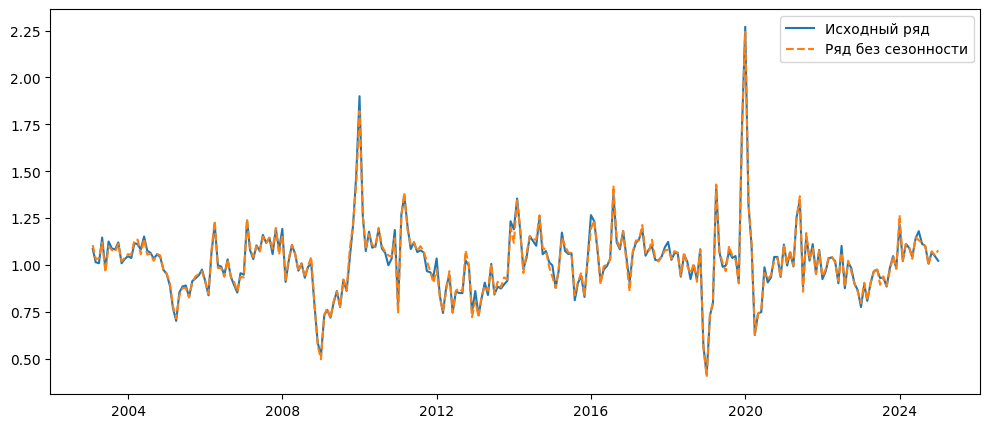

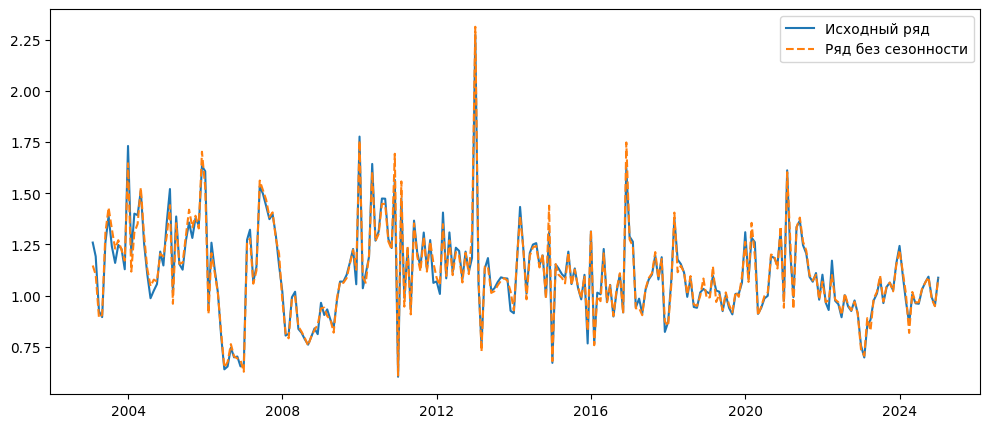

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


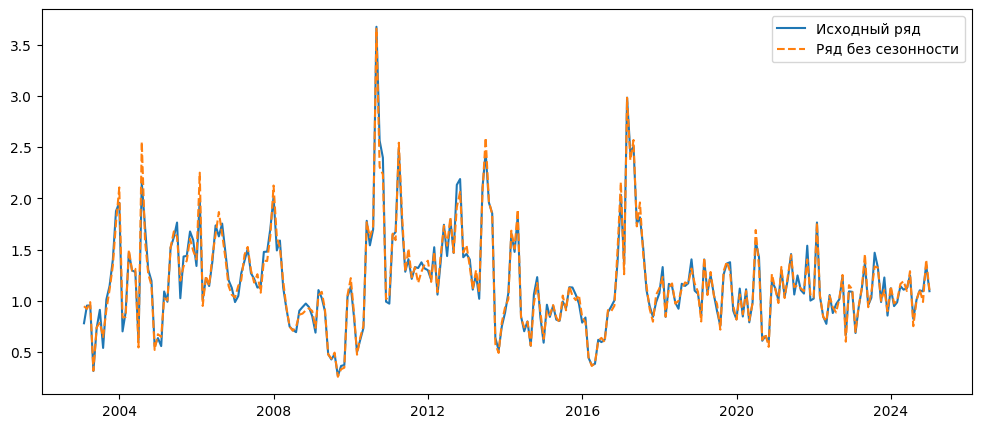

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


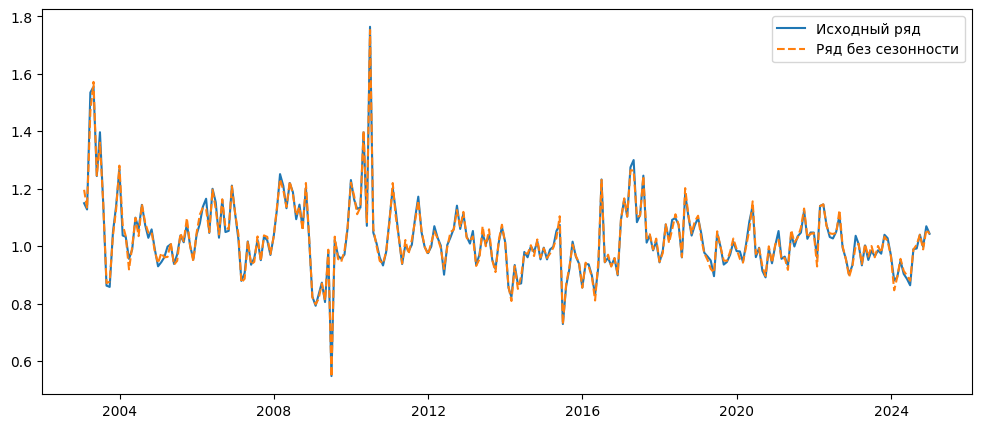

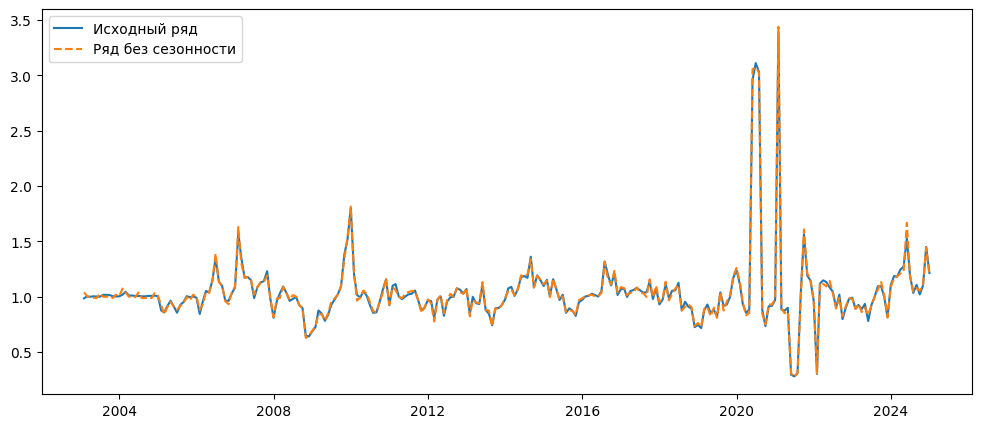

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


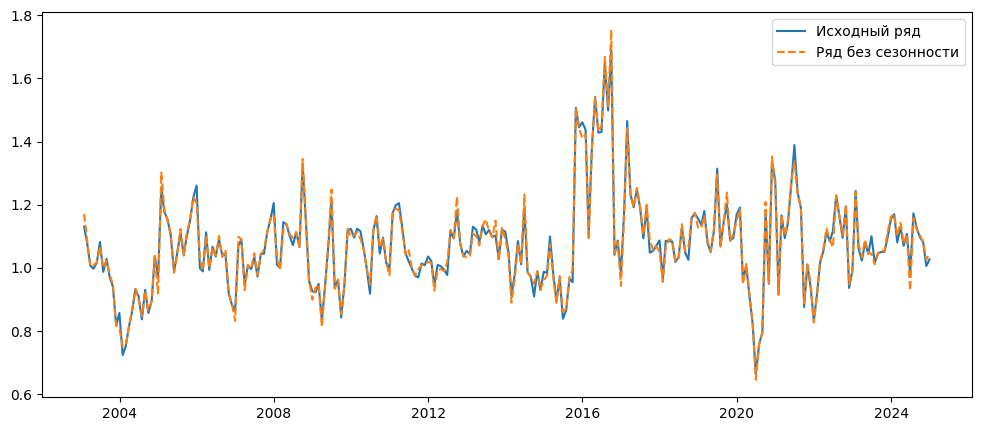

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


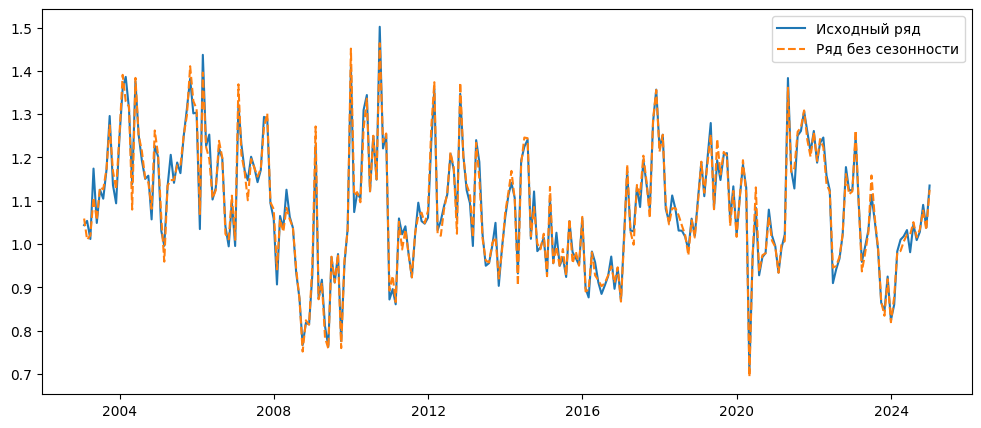

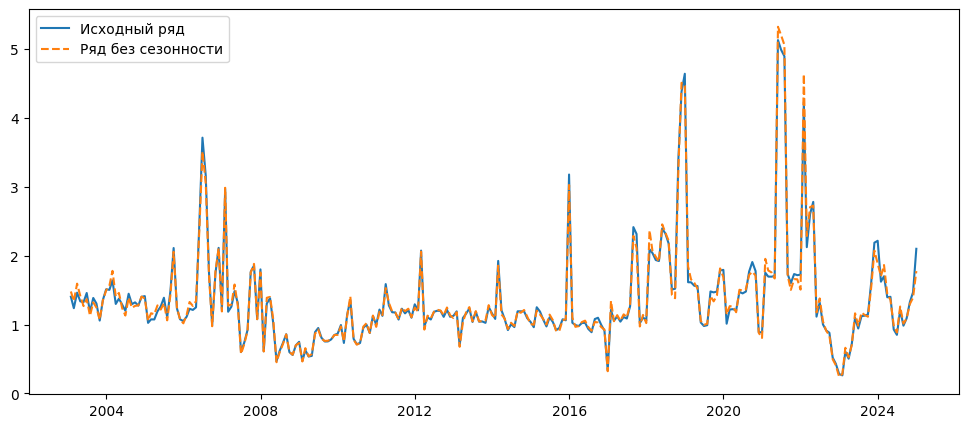

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: NOTE: Cannot perform test for constant term:
       Model estimation does not converge when constant term added.

       Constant term will not be included in regARIMA model

  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


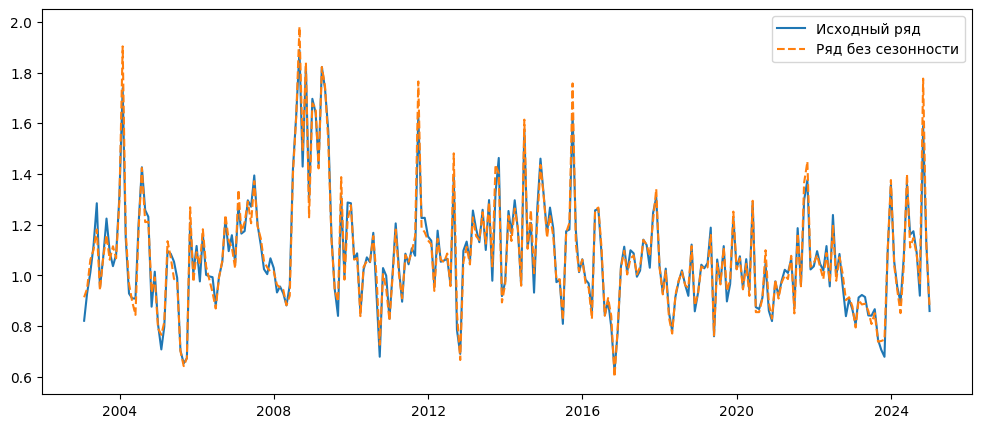

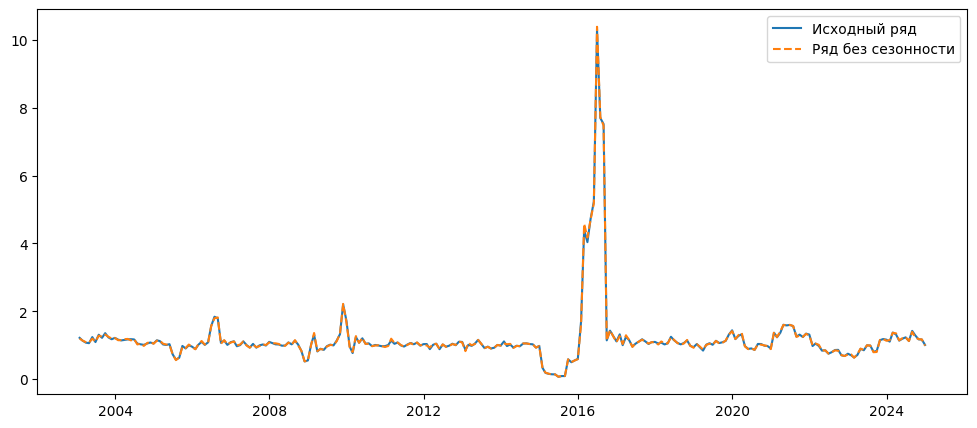

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


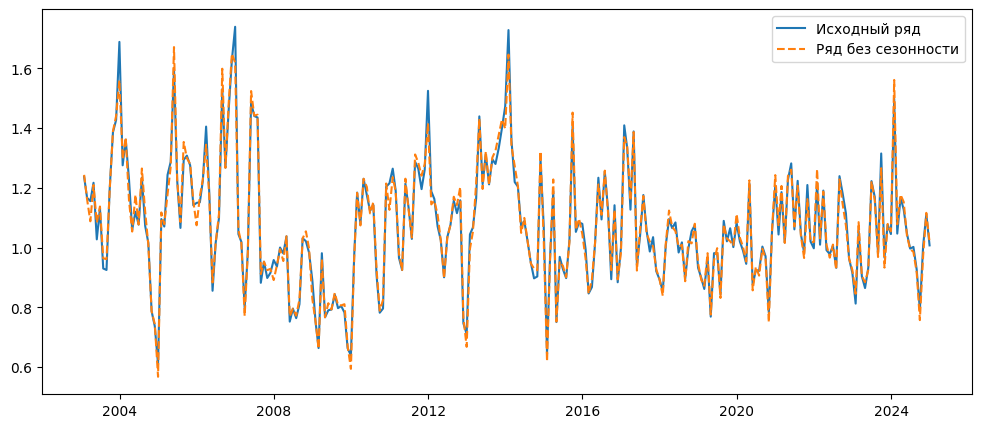

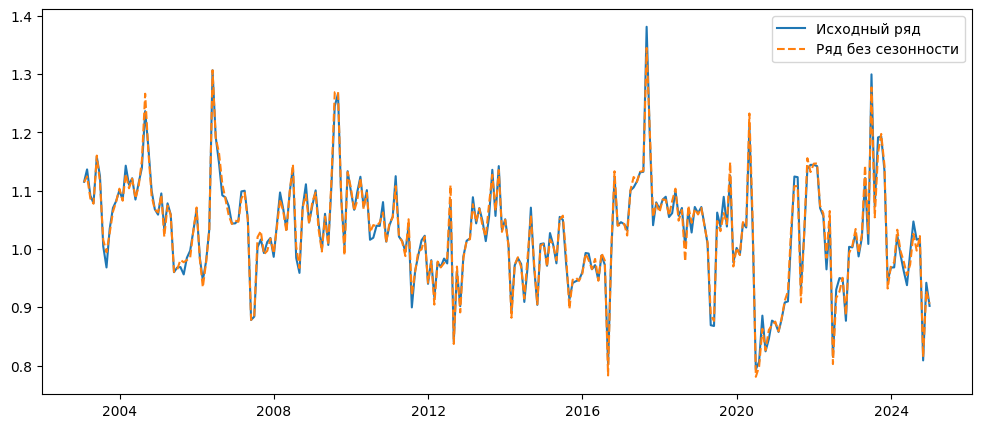

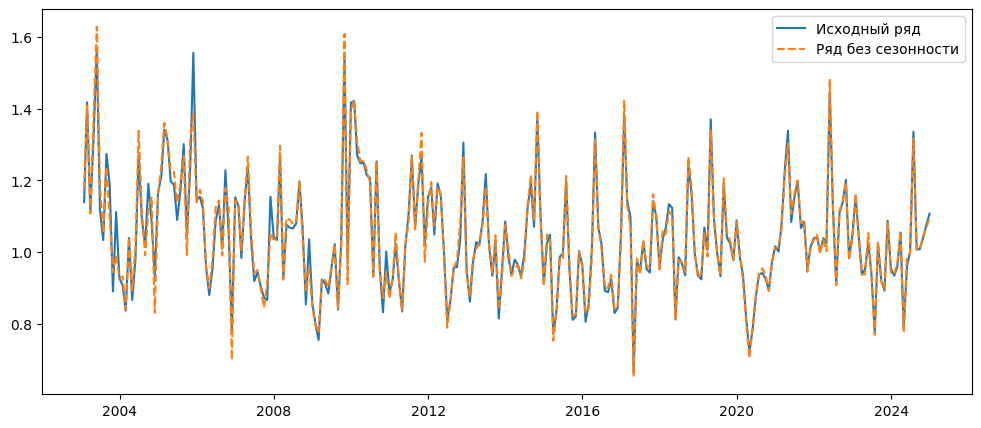

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


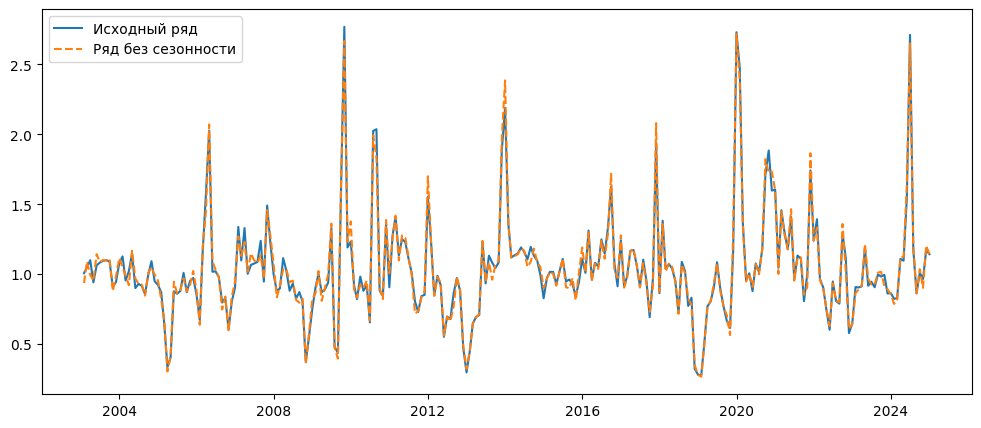

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


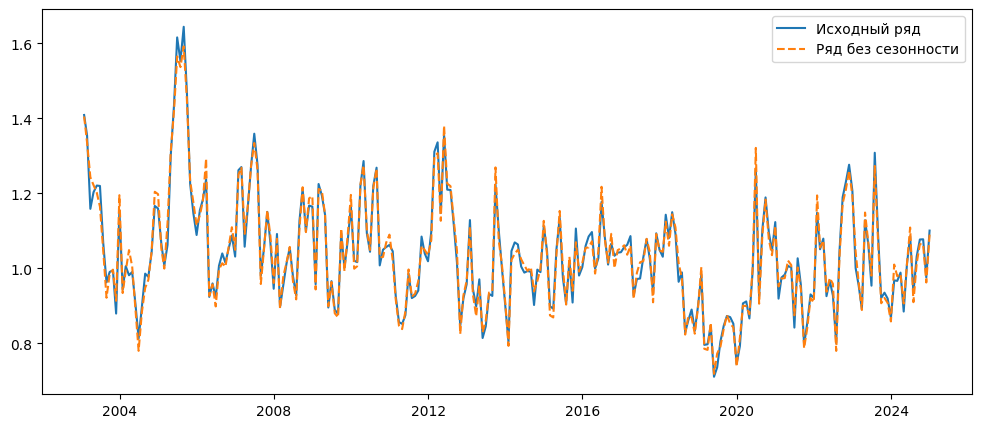

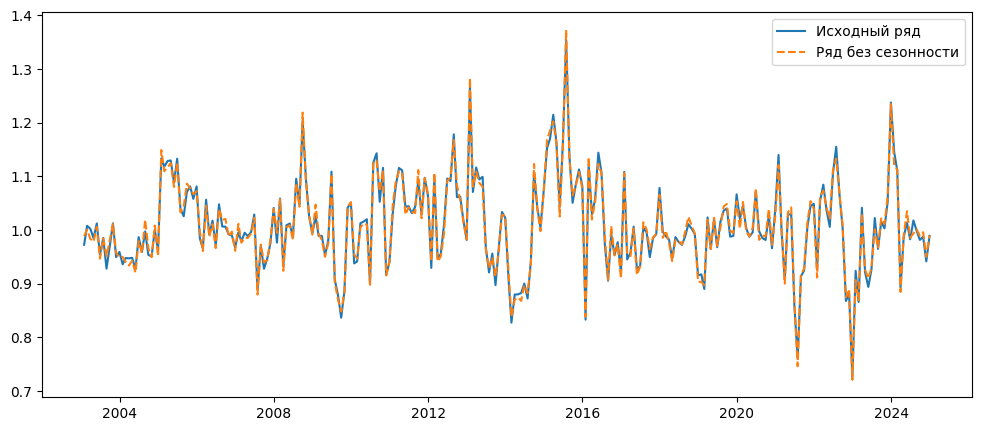

In [113]:
import matplotlib.pyplot as plt

for idx, row in df_2003_2024_with_index.iterrows():

  data = row

  res = sm.tsa.x13_arima_analysis(data, freq='M')

  adjusted_series = res.seasadj

  plt.figure(figsize=(12,5))
  plt.plot(data, label="Исходный ряд")
  plt.plot(adjusted_series, label="Ряд без сезонности", linestyle="dashed")
  plt.legend()
  plt.show()